In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [4]:
data=pd.read_csv('AMZN.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6511,2023-03-30,101.550003,103.040001,101.010002,102.000000,102.000000,53633400
6512,2023-03-31,102.160004,103.489998,101.949997,103.290001,103.290001,56704300
6513,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
6514,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500


In [6]:
data=data[['Date','Close']]
data

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6511,2023-03-30,102.000000
6512,2023-03-31,103.290001
6513,2023-04-03,102.410004
6514,2023-04-04,103.949997


In [7]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

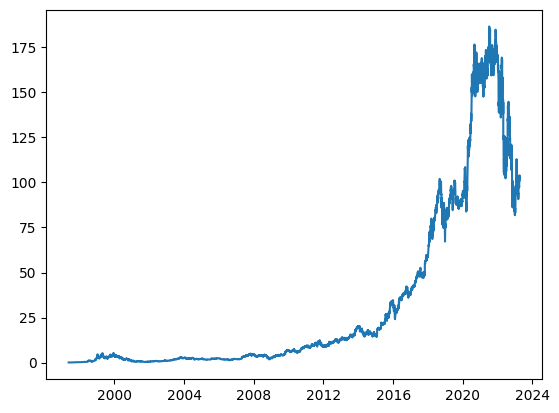

In [8]:
data['Date']=pd.to_datetime(data['Date'])
plt.plot(data['Date'],data['Close'])

In [9]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df,n_steps):
    df=dc(df)
    df.set_index('Date',inplace=True)
    for i in range(1,n_steps+1):
        df[f'Close(t-{i})']=df['Close'].shift(i)
    
    df.dropna(inplace=True)

    return df


look_back=7
shifted_df=prepare_dataframe_for_lstm(data,look_back)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999


In [10]:
shifted_df_as_np=shifted_df.to_numpy()
shifted_df_as_np.shape

(6509, 8)

In [11]:
# scaling the value
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(-1,1))
shifted_df_as_np=scaler.fit_transform(shifted_df_as_np)
shifted_df_as_np


array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

In [12]:
# X  ,  Y
x=shifted_df_as_np[:,1:]
y=shifted_df_as_np[:,0]

x=dc(np.flip(x,axis=1))
print(x,y)

[[-0.99969839 -0.99982128 -0.99983244 ... -0.99998325 -1.
  -0.99995531]
 [-0.99982128 -0.99983244 -0.99987154 ... -1.         -0.99994415
  -0.99991063]
 [-0.99983244 -0.99987154 -0.99998325 ... -0.99994415 -0.99989946
  -0.99993855]
 ...
 [ 0.05779984  0.05158     0.0506149  ...  0.07431453  0.09308121
   0.10690997]
 [ 0.05158     0.0506149   0.04203581 ...  0.09308121  0.10691495
   0.09747299]
 [ 0.0506149   0.04203581  0.07431453 ...  0.10691495  0.09747802
   0.11398769]] [-0.99991063 -0.99993855 -0.99995253 ...  0.09747299  0.11398769
  0.08342464]


In [13]:
# train test split
split_index=int(len(x)*0.95)
x_train=x[:split_index]
x_test=x[split_index:]

y_train=y[:split_index]
y_test=y[split_index:]

x_train,x_test,y_train,y_test

(array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
         -1.        , -0.99995531],
        [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
         -0.99994415, -0.99991063],
        [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
         -0.99989946, -0.99993855],
        ...,
        [ 0.81682649,  0.83697653,  0.88840802, ...,  0.86703009,
          0.84602214,  0.81766197],
        [ 0.83697653,  0.88840802,  0.88833832, ...,  0.84602214,
          0.81766298,  0.81255742],
        [ 0.88840802,  0.88833832,  0.86703009, ...,  0.81766298,
          0.81255847,  0.85784967]]),
 array([[0.88833832, 0.86703009, 0.84602214, ..., 0.81255847, 0.85785047,
         0.81019275],
        [0.86703009, 0.84602214, 0.81766298, ..., 0.85785047, 0.81019381,
         0.82248768],
        [0.84602214, 0.81766298, 0.81255847, ..., 0.81019381, 0.82248867,
         0.79097548],
        ...,
        [0.05779984, 0.05158   , 0.0506149 , ..., 0.07431453, 0.09308121

In [14]:
# make them 3d to convert into tensor
x_train=x_train.reshape((len(x_train),look_back,1))
x_test=x_test.reshape((len(x_test),look_back,1))

y_train=y_train.reshape((len(y_train),1))
y_test=y_test.reshape((len(y_test),1))


x_train=torch.tensor(x_train).float()
x_test=torch.tensor(x_test).float()
y_train=torch.tensor(y_train).float()
y_test=torch.tensor(y_test).float()






In [15]:
#  convert into timeseries dataset and dataloader

from torch.utils.data import Dataset
class Time_series_dataset(Dataset):
    def __init__(self,x,y):
        self.x=x
        self.y=y


    def __len__(self):
        return len(self.x)
    

    def __getitem__(self,i):
        return self.x[i],self.y[i]

train_dataset=Time_series_dataset(x_train,y_train)
test_dataset=Time_series_dataset(x_test,y_test)

In [20]:
from torch.utils.data import DataLoader

batch_size=16

train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=True)




In [21]:
# design the LSTM model

class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_stacked_layers):
        super().__init__()
        self.hidden_size=hidden_size
        self.num_stacked_layers=num_stacked_layers

        self.lstm=nn.LSTM(input_size,hidden_size,num_stacked_layers,batch_first=True)

        self.fc=nn.Linear(hidden_size,1)


    def forward(self,x):
        batch_size=x.size(0)

        h0=torch.zeros(self.num_stacked_layers,batch_size,self.hidden_size).to(device)
        c0=torch.zeros(self.num_stacked_layers,batch_size,self.hidden_size).to(device)

        out,(hn,cn)=self.lstm(x,(h0,c0))

        out=self.fc(out[:,-1,:])

        return out
    


model=LSTM(1,4,1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [22]:
# lr,loss,optimizer

learning_rate=0.001
num_epochs=10
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [28]:
# train one epoch
def train_one_epoch():
    model.train(True)
    running_loss=0.0
    for batch_index,batch in enumerate(train_loader):
        x_batch,y_batch=batch[0].to(device),batch[1].to(device)

        output=model(x_batch)
        loss=criterion(output,y_batch)
        running_loss+=loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        

In [29]:
# validate one epoch

def validate_one_epoch():
    model.train(False)
    running_loss=0.0
    for batch_index,batch in enumerate(test_loader):
        x_batch,y_batch=batch[0].to(device),batch[1].to(device)

        with torch.no_grad():
          output=model(x_batch)
          loss=criterion(output,y_batch)
          running_loss+=loss.item()

      

In [30]:
for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()
    

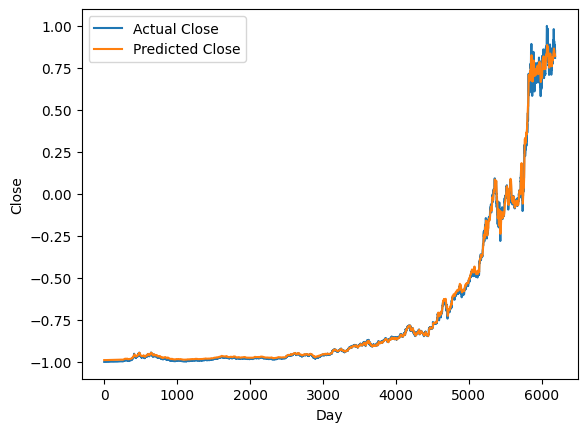

In [31]:
with torch.no_grad():
    predicted = model(x_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

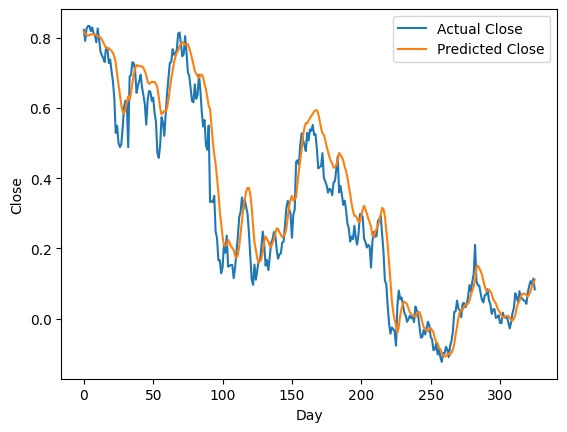

In [32]:
with torch.no_grad():
    predicted = model(x_test.to(device)).to('cpu').numpy()

plt.plot(y_test, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [36]:
import pandas as pd

# Convert the course structure into a structured format for Excel
course_structure = [
    {"Level": "0", "Title": "Prerequisites & Python Refresher", "Duration": "1 week", "Topics": "Python basics, NumPy, Matplotlib, basic math, probability", "Project": "Linear regression from scratch using NumPy"},
    {"Level": "1", "Title": "PyTorch Fundamentals", "Duration": "1 week", "Topics": "Tensors, autograd, torch.nn, optim, DataLoader, training loops", "Project": "Linear regression with PyTorch"},
    {"Level": "2", "Title": "Neural Networks (Fully Connected)", "Duration": "1 week", "Topics": "MLP, activation functions, loss functions, optimizers", "Project": "MNIST digit classification"},
    {"Level": "3", "Title": "Convolutional Neural Networks (CNN)", "Duration": "1–2 weeks", "Topics": "Convolution, pooling, CNN architectures, transfer learning", "Project": "CIFAR-10 or Fashion-MNIST, pretrained ResNet"},
    {"Level": "4", "Title": "Recurrent Neural Networks (RNN)", "Duration": "1 week", "Topics": "Sequence modeling, implementing RNN, limitations", "Project": "Character-level name generator"},
    {"Level": "5", "Title": "LSTM & GRU", "Duration": "1 week", "Topics": "LSTM internals, GRU, sequence padding, NLP tasks", "Project": "IMDB sentiment analysis"},
    {"Level": "6", "Title": "Attention Mechanism", "Duration": "1 week", "Topics": "Additive vs dot-product attention, Seq2Seq attention", "Project": "Machine translation with attention"},
    {"Level": "7", "Title": "Transformers", "Duration": "1–2 weeks", "Topics": "Positional Encoding, Transformer architecture, HuggingFace", "Project": "Text classification with BERT, text generation with GPT-2"},
    {"Level": "8", "Title": "Advanced Topics (Vision/NLP/Time Series)", "Duration": "Flexible", "Topics": "YOLO, U-Net, BERT, RoBERTa, GPT, forecasting", "Project": "Choose based on track"},
    {"Level": "9", "Title": "Capstone Project", "Duration": "2–3 weeks", "Topics": "Integration of concepts", "Project": "News summarizer, COVID-19 forecasting, image captioning"},
    {"Level": "10", "Title": "Future Work & Research", "Duration": "Ongoing", "Topics": "Diffusion models, RL, multimodal, LLMs, XAI, TinyML", "Project": "Exploration and paper reading"}
]

df = pd.DataFrame(course_structure)
excel_path = "LSTM_amazon_stock_forecasting.xlsx"
df.to_excel(excel_path, index=False)

excel_path



'LSTM_amazon_stock_forecasting.xlsx'